In [ ]:
# !pip install anthropic
# !pip install voyageai
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# %pip install -U scikit-learn

### API

# Get the VOYAGE_API_KEY


In [1]:
%env VOYAGE_API_KEY=YOUR_API_KEY

env: VOYAGE_API_KEY=YOUR_API_KEY


In [ ]:
%env ANTHROPIC_API_KEY=

In [ ]:
# Setup our environment
import anthropic
import os

client = anthropic.Anthropic(
    # This is the default and can be omitted
    api_key=os.environ.get("ANTHROPIC_API_KEY"),
)

### Labeled Data

# Todo : Create /test.tsv /train.tsv files

In [ ]:
import pandas as pd

data = {
    'train': [],
    'test': [],
    'test_2': []
}

# Helper function to convert a DataFrame to a list of dictionaries
def dataframe_to_dict_list(df):
    return df.apply(lambda x: {'text': x['text'], 'label': x['label']}, axis=1).tolist()


# Read the TSV file into a DataFrame
test_df = pd.read_csv("./data/test.tsv", sep='\t')
data['test'] = dataframe_to_dict_list(test_df)

train_df = pd.read_csv("./data/train.tsv", sep='\t')
data['train'] = dataframe_to_dict_list(train_df)


# Understand the labels in the dataset
labels = list(set(train_df['label'].unique()))

# Print the first training example and the number of training examples
print(data['train'][0], len(data['train']))

# Create the test set
X_test = [example['text'] for example in data['test']]
y_test = [example['label'] for example in data['test']]

# Print the length of the test set
print(len(X_test), len(y_test))

{'text': 'I just got my auto policy renewal bill and the cost seems to be more than what I usually pay. Could you explain the reason for the increase?', 'label': 'Billing Inquiries'} 68
68 68


### Evaluating each classification model


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import concurrent.futures
import numpy as np

MAXIMUM_CONCURRENT_REQUESTS = 5

def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def evaluate(X, y, classifier, batch_size=MAXIMUM_CONCURRENT_REQUESTS):
    # Initialize lists to store the predicted and true labels
    y_true = []
    y_pred = []

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the classification tasks to the executor in batches
        futures = []
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_futures = [executor.submit(classifier, x) for x in batch_X]
            futures.extend(batch_futures)

        # Retrieve the results in the original order
        for i, future in enumerate(futures):
            predicted_label = future.result()
            y_pred.append(predicted_label)
            y_true.append(y[i])

    # Normalize y_true and y_pred
    y_true = [label.strip() for label in y_true]
    y_pred = [label.strip() for label in y_pred]

    # Calculate the classification metrics
    report = classification_report(y_true, y_pred, zero_division=1)
    cm = confusion_matrix(y_true, y_pred)
    print(report)
    plot_confusion_matrix(cm, labels)

### Random Classifier

In [ ]:
import random

def random_classifier(text):
    return random.choice(labels)

Evaluating the random classification method on the test set...
                       precision    recall  f1-score   support

   Account Management       0.00      0.00      0.00         6
     Billing Disputes       0.00      0.00      0.00         9
    Billing Inquiries       0.14      0.17      0.15         6
    Claims Assistance       0.20      0.33      0.25         6
      Claims Disputes       0.00      0.00      0.00         9
Coverage Explanations       0.11      0.11      0.11         9
    General Inquiries       0.25      0.14      0.18         7
Policy Administration       0.29      0.33      0.31         6
   Policy Comparisons       0.00      0.00      0.00         5
 Quotes and Proposals       0.00      0.00      0.00         5

             accuracy                           0.10        68
            macro avg       0.10      0.11      0.10        68
         weighted avg       0.10      0.10      0.10        68



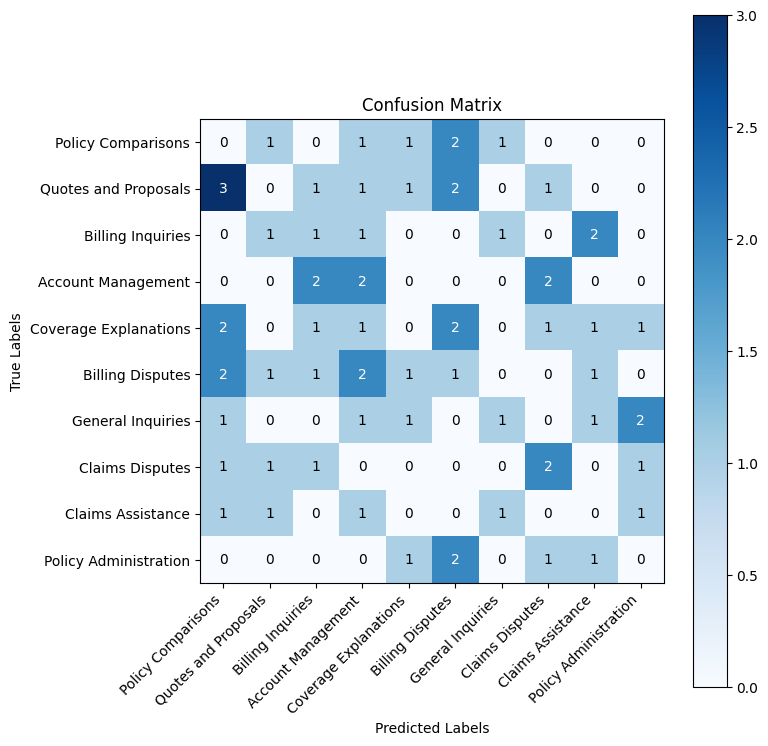

In [ ]:
print("Evaluating the random classification method on the test set...")
evaluate(X_test, y_test, random_classifier)

### Simple Classification Test

# Todo : Update Label, Content 

In [ ]:
import textwrap
categories = textwrap.dedent("""<category> 
    <label>Billing Inquiries</label>
    <content> Questions about invoices, charges, fees, and premiums Requests for clarification on billing statements Inquiries about payment methods and due dates 
    </content> 
</category> 
<category> 
    <label>Policy Administration</label>
    <content> Requests for policy changes, updates, or cancellations Questions about policy renewals and reinstatements Inquiries about adding or removing coverage options 
    </content> 
</category> 
<category> 
    <label>Claims Assistance</label> 
    <content> Questions about the claims process and filing procedures Requests for help with submitting claim documentation Inquiries about claim status and payout timelines 
    </content> 
</category> 
<category> 
    <label>Coverage Explanations</label> 
    <content> Questions about what is covered under specific policy types Requests for clarification on coverage limits and exclusions Inquiries about deductibles and out-of-pocket expenses 
    </content> 
</category> 
<category> 
    <label>Quotes and Proposals</label> 
    <content> Requests for new policy quotes and price comparisons Questions about available discounts and bundling options Inquiries about switching from another insurer 
    </content> 
</category> 
<category> 
    <label>Account Management</label> 
    <content> Requests for login credentials or password resets Questions about online account features and functionality Inquiries about updating contact or personal information 
    </content> 
</category> 
<category> 
    <label>Billing Disputes</label> 
    <content> Complaints about unexpected or incorrect charges Requests for refunds or premium adjustments Inquiries about late fees or collection notices 
    </content> 
</category> 
<category> 
    <label>Claims Disputes</label> 
    <content> Complaints about denied or underpaid claims Requests for reconsideration of claim decisions Inquiries about appealing a claim outcome 
    </content> 
</category> 
<category> 
    <label>Policy Comparisons</label> 
    <content> Questions about the differences between policy options Requests for help deciding between coverage levels Inquiries about how policies compare to competitors' offerings 
    </content> 
</category> 
<category> 
    <label>General Inquiries</label> 
    <content> Questions about company contact information or hours of operation Requests for general information about products or services Inquiries that don't fit neatly into other categories 
    </content> 
</category>""")

### Prompt Template

# Todo : Improve Prompt

In [ ]:
def simple_classify(X):
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X)
    response = client.messages.create( 
        messages=[{"role":"user", "content": prompt}, {"role":"assistant", "content": "<category>"}],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model="claude-3-haiku-20240307"),
    
    # Extract the result from the response
    result = response[0].content[0].text.strip()
    return result

In [ ]:
print("Evaluating the simple classification method on the test set...")
evaluate(X_test, y_test, simple_classify)

### Simple VectorDB class

In [ ]:
import os
import numpy as np
import voyageai
import pickle
import json

class VectorDB:
    def __init__(self, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = "./data/vector_db.pkl"

    def load_data(self, data):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [item["text"] for item in data]

        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            self.client.embed(
                texts[i : i + batch_size],
                model="voyage-2"
            ).embeddings
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = [item for item in data]
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=5, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

In [ ]:
vectordb = VectorDB()
vectordb.load_data(data["train"])

### RAG Classification Prompt

In [ ]:
def rag_classify(X):
    rag = vectordb.search(X,5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    response = client.messages.create( 
        messages=[{"role":"user", "content": prompt}, {"role":"assistant", "content": "<category>"}],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model="claude-3-haiku-20240307"),
    
    # Extract the result from the response
    result = response[0].content[0].text.strip()
    return result


In [ ]:
print("Evaluating the RAG method on the test set...")
evaluate(X_test, y_test, rag_classify)

### RAG Classification with Chain of Thought Prompt


### Todo : Update the prompt

In [ ]:
def rag_chain_of_thought_classify(X):
    rag = vectordb.search(X,5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    First you will think step-by-step about the problem in scratchpad tags.
    You should consider all the information provided and create a concrete argument for your classification.
    
    Respond using this format:
    <response>
        <scratchpad>Your thoughts and analysis go here</scratchpad>
        <category>The category label you chose goes here</category>
    </response>
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    response = client.messages.create( 
        messages=[{"role":"user", "content": prompt}, {"role":"assistant", "content": "<response><scratchpad>"}],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model="claude-3-haiku-20240307"),
    
    # Extract the result from the response
    result = response[0].content[0].text.split("<category>")[1].strip()
    return result

In [ ]:
print("Evaluating the RAG method with Chain of Thought on the test set...")
evaluate(X_test, y_test, rag_chain_of_thought_classify)

### Evaluation

In [ ]:
import json
import pandas as pd

promptfoo_results = pd.read_csv("./data/results.csv")
examples_columns = promptfoo_results.columns[2:]

number_of_providers = 5
number_of_prompts = 3

prompts = ["Simple", "RAG", "RAG w/ CoT"]

columns = ["label", "text"] + [
    json.loads(examples_columns[prompt * number_of_providers + provider])["provider"]
    + " Prompt: "
    + str(prompts[prompt])
    for prompt in range(number_of_prompts)
    for provider in range(number_of_providers)
]

promptfoo_results.columns = columns

result = (
    promptfoo_results.iloc[:, 2:]
    .astype(str)
    .apply(lambda x: x.str.count("PASS"))
    .sum()
    / len(promptfoo_results)
    * 100
).sort_values(ascending=False)

print(result)